In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import foolbox as fb
import matplotlib.pyplot as plt
import os

In [41]:
# Cargar el modelo VGG16 preentrenado
model = VGG16(weights='imagenet')

In [42]:
# Cargar y preprocesar la imagen
img_path = os.path.join('data', 'Tiger_shark.jpg')
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

In [43]:
# Preparar el preprocesamiento para el modelo Foolbox, convertir mean y std a tensores
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])
preprocessing = {'mean': mean, 'std': std}

# Convertir el modelo de Keras a un modelo compatible con Foolbox
fmodel = fb.TensorFlowModel(model, bounds=(0, 1), preprocessing=preprocessing)

# Aplicar manualmente el preprocesamiento usando TensorFlow para evitar problemas de compatibilidad
x = (tf.convert_to_tensor(x) - mean) / std

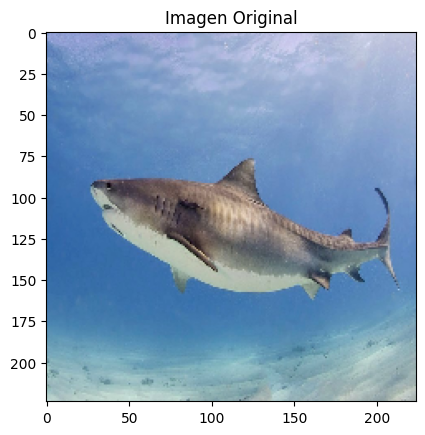

In [44]:
# Mostrar la imagen original (antes del preprocesamiento)
plt.imshow(img.convert('RGB'))
plt.title("Imagen Original")
plt.show()

In [45]:
# Definir el tamaño y la posición del parche
patch_size = 50
patch = np.random.rand(patch_size, patch_size, 3)  # Parche inicial aleatorio
patch_center = (112, 112)  # Centro del parche

# Optimizar el parche adversario
learning_rate = 0.1
iterations = 50
target_label = 282  # Etiqueta objetivo (por ejemplo, "tiger cat" en ImageNet)


In [49]:
# Función para aplicar el parche a la imagen
def apply_patch(image, patch, center):
    image_shape = tf.shape(image)
    patch_shape = tf.shape(patch)
    start_x = center[0] - patch_shape[0] // 2
    start_y = center[1] - patch_shape[1] // 2

    # Create a mask to insert the patch
    mask = tf.zeros_like(image)
    mask = tf.tensor_scatter_nd_update(
        mask,
        indices=[[0, start_x + i, start_y + j, k] for i in range(patch_shape[0]) for j in range(patch_shape[1]) for k in range(patch_shape[2])],
        updates=tf.reshape(patch, [-1])
    )

    patched_image = image * (1 - mask) + mask
    return patched_image

In [47]:
# Convertir el parche a un tensor y asegurarse de que el tipo de datos es float32
patch = np.random.rand(patch_size, patch_size, 3).astype(np.float32)
patch = tf.Variable(patch, dtype=tf.float32)

# Optimizar el parche
optimizer = tf.optimizers.Adam(learning_rate)

In [50]:
for i in range(iterations):
    with tf.GradientTape() as tape:
        tape.watch(patch)
        patched_image = apply_patch(x, patch, patch_center)
        preds = fmodel(patched_image)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=[target_label], logits=preds)
    
    grads = tape.gradient(loss, patch)
    if grads is not None:
        optimizer.apply_gradients([(grads, patch)])
    else:
        print('No se encontraron gradientes.')
    
    # Clip del parche para mantenerlo en el rango válido
    patch.assign(tf.clip_by_value(patch, -3, 3))  # Ajusta según el rango de tu imagen preprocesada
    
    print(f'Iteración {i}, Pérdida: {np.mean(loss.numpy())}')


Iteración 0, Pérdida: 6.908463001251221
Iteración 1, Pérdida: 6.907909870147705
Iteración 2, Pérdida: 6.9058685302734375
Iteración 3, Pérdida: 6.899198532104492
Iteración 4, Pérdida: 6.888301372528076
Iteración 5, Pérdida: 6.871500492095947
Iteración 6, Pérdida: 6.849615097045898
Iteración 7, Pérdida: 6.825251579284668
Iteración 8, Pérdida: 6.797694206237793
Iteración 9, Pérdida: 6.763763904571533
Iteración 10, Pérdida: 6.728679656982422
Iteración 11, Pérdida: 6.687576770782471
Iteración 12, Pérdida: 6.650688648223877
Iteración 13, Pérdida: 6.607872009277344
Iteración 14, Pérdida: 6.568125247955322
Iteración 15, Pérdida: 6.527587413787842
Iteración 16, Pérdida: 6.4872636795043945
Iteración 17, Pérdida: 6.453583240509033
Iteración 18, Pérdida: 6.42110538482666
Iteración 19, Pérdida: 6.392662048339844
Iteración 20, Pérdida: 6.366879940032959
Iteración 21, Pérdida: 6.342174530029297
Iteración 22, Pérdida: 6.319006443023682
Iteración 23, Pérdida: 6.296923637390137
Iteración 24, Pérdida: 6.

In [51]:
# Aplicar el parche optimizado a la imagen
adversarial_image = apply_patch(x, patch, patch_center)

# Revertir el preprocesamiento para la visualización
adversarial_image_display = (adversarial_image[0] * preprocessing['std'] + preprocessing['mean']) * 255
adversarial_image_display = np.clip(adversarial_image_display, 0, 255).astype(np.uint8)

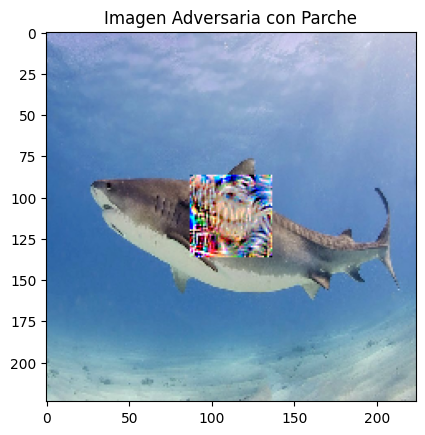

In [52]:
# Mostrar la imagen adversaria
plt.imshow(adversarial_image_display)
plt.title("Imagen Adversaria con Parche")
plt.show()

In [53]:
# Predecir con la imagen adversaria utilizando el modelo original
preds = model.predict(adversarial_image)
print('Predicción adversaria:', decode_predictions(preds, top=1)[0])

1/1 [==============================] - 2s 2s/step
Predicción adversaria: [('n02123159', 'tiger_cat', 0.15462528)]


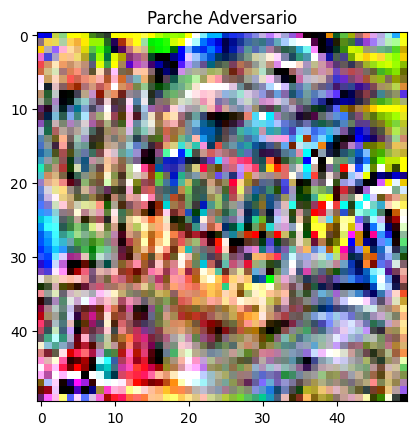

In [54]:

# Mostrar el parche adversario
patch_display = (patch.numpy() * preprocessing['std'] + preprocessing['mean']) * 255
patch_display = np.clip(patch_display, 0, 255).astype(np.uint8)
plt.imshow(patch_display)
plt.title("Parche Adversario")
plt.show()